In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.xkcd()
import seaborn as sns
import datetime
from pymaran import gSheets
import io
import requests
from dateutil.rrule import rrule, MONTHLY

# Get Data

In [2]:
### Germany
de = pd.DataFrame(gSheets.readSheet("covidCrawlen").worksheet("data").get_all_values())
de.columns = de.iloc[0]
de = de[1:]

In [3]:
de.loc[de["city"] == "Nordrhein-West­falen", "city"] = "Nordrhein-Westfalen"
de.loc[de["city"] == "Rhein­land-Pfalz", "city"] = "Rheinland-Pfalz"
de.loc[de["city"] == "Schles­wig-Holstein", "city"] = "Schleswig Holstein"
de.loc[de["city"] == "Schleswig Holstein", "city"] = "Schleswig-Holstein"
de.loc[de["city"] == "Baden-Württem­berg", "city"] = "Baden-Wurttemberg"
de.loc[de["city"] == "Baden-Württemberg", "city"] = "Baden-Wurttemberg"
de.loc[de["city"] == "Mecklenburg-Vor­pommern", "city"] = "Mecklenburg-Vorpommern"
de.loc[de["city"] == "Mecklenburg-\nVor­pommern", "city"] = "Mecklenburg-Vorpommern"
de.loc[de["city"] == "Thüringen", "city"] = "Thuringen"
de.loc[de["city"] == "Gesamt", "city"] = "Total"

In [4]:
de["total_cases"] = pd.to_numeric(de["total_cases"])
de["old_date"] = pd.to_datetime(de["date"], format="%d/%m/%Y", errors="coerce")
de["new_date"] = pd.to_datetime(de["date"], format="%Y-%m-%d", errors="coerce")
de["date"] = de["old_date"].fillna(de["new_date"])
de.drop(columns=["old_date", "new_date"], inplace=True)

In [5]:
### World
url = "https://datahub.io/core/covid-19/r/time-series-19-covid-combined.csv"
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode("utf-8")))

In [6]:
c["Date"] = pd.to_datetime(c["Date"])
world = c.groupby(["Country/Region", "Date"])["Confirmed"].sum().reset_index()
world.columns = ["country", "date", "cases"]

## Process

In [7]:
def getAvg(x, days=7):
    global story
    story = []
    for i in range(days):
        if i is not np.NaN:
            story.append(x.shift(i)["growth"])

    # return np.mean([x[-1:].values for x in story])
    return pd.DataFrame([x[:] for x in story]).apply(lambda x: np.mean(x), axis=0)

In [8]:
def processCases(df, group="state", var="total_cases"):
    df = df.sort_values("date")
    day_data = df.groupby(group).apply(lambda x: x[[var]] - x.shift(1)[[var]])
    day_data.columns = ["growth"]
    active_data = df.groupby(group).apply(
        lambda x: x[[var]] - x.shift(14)[[var]].fillna(0)
    )
    active_data.columns = ["active cases"]
    df = df.join(day_data, rsuffix="_")
    df = df.join(
        pd.DataFrame(
            df.groupby(group).apply(lambda x: getAvg(x, 7)), columns=["avg growth"]
        )
        .reset_index()
        .set_index("level_1")
        .drop(group, axis=1)
    )
    df = df.join(active_data)
    return df

In [9]:
total = world.groupby("date")["cases"].sum().reset_index()
total["country"] = "World"

In [10]:
world = world.append(total).reset_index(drop=True)

In [11]:
de = processCases(de, "city")
world = processCases(world, "country", "cases")

In [12]:
de.columns = [
    "state",
    "total cases",
    "total deaths",
    "date",
    "growth",
    "avg growth",
    "active cases",
]
world.columns = [
    "country",
    "date",
    "total cases",
    "growth",
    "avg growth",
    "active cases",
]

In [13]:
countryList = [
    "Argentina",
    "Indonesia",
    "Mexico",
    "Finland",
    "New Zealand",
    "Australia",
    "Spain",
    "United Kingdom",
    "China",
    "US",
    "Iran",
    "Germany",
    "Brazil",
    "France",
    "Italy",
    "Korea, South",
]
stateList = [
    "Berlin",
    "Bayern",
    "Bremen",
    "Hamburg",
    "Hessen",
    "Thuringen",
    "Niedersachsen",
    "Total",
    "Nordrhein-Westfalen",
    "Baden-Wurttemberg",
]

In [14]:
w = world[world["country"].isin(countryList)]
w.sort_values(["country", "date"], inplace=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
def datePlot(title, subtitle, file, data, var="total cases", hue="country"):
    months = [
        dt
        for dt in rrule(
            MONTHLY, dtstart=data["date"].min().replace(day=1), until=data["date"].max()
        )
    ]
    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title(title)
    if subtitle != "":
        sup = plt.suptitle(subtitle, fontsize=12, y=0, alpha=0.5)

    sns.lineplot("date", var, hue=hue, data=data)
    ax.set_xticks(months)
    ax.set_xlim(data["date"].min(), data["date"].max() + datetime.timedelta(days=14))
    for i, ls in data.sort_values(var, ascending=False).groupby(hue).first().iterrows():
        ax.annotate(i, (ls["date"], ls[var]), clip_on=True)

    ax.legend(loc="upper left", fontsize=12, ncol=2)
    plt.savefig(file, bbox_inches="tight", bbox_extra_artists=[sup])

In [16]:
def linePlot(
    title, subtitle, file, data, x="total cases", y="avg growth", hue="country"
):

    fig, ax = plt.subplots(figsize=(13, 7))
    plt.title(title)
    if subtitle != "":
        sup = plt.suptitle(subtitle, fontsize=12, y=0, alpha=0.5)

    sns.lineplot(x, y, hue=hue, data=data)
    #    ax.set_xlim(data['date'].min(), data['date'].max() + datetime.timedelta(days=14))
    for i, ls in data.sort_values(y, ascending=False).groupby(hue).first().iterrows():
        ax.annotate(i, (ls[x], ls[y]), clip_on=True)

    ax.legend(loc="upper left", fontsize=12, ncol=2)

    plt.savefig(file, bbox_inches="tight", bbox_extra_artists=[sup])

In [17]:
def logPlot(
    title,
    subtitle,
    file,
    data,
    hue="country",
    x="total cases",
    y="avg growth",
    autoLim=True,
    xlim=[10 ** 4, 10 ** 6.5],
    ylim=[10 ** 4, 10 ** 6.5],
    legend=True,
):

    fig, ax = plt.subplots(figsize=(13, 10))
    plt.title(title)
    if subtitle != "":
        sup = plt.suptitle(subtitle, fontsize=12, y=0, alpha=0.5)

    sns.lineplot(x, y, hue=hue, sort=False, data=data)

    if autoLim:
        ax.set_xlim([10, data[x].max() * 10 ** 0.5])
        ax.set_ylim([10, data[y].max() * 10 ** 0.5])
    else:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    ax.set_xscale("log")
    ax.set_yscale("log")

    if legend:
        ax.legend(loc="upper left", fontsize=12, ncol=2)
    else:
        ax.legend().remove()

    for i, ls in data.groupby(hue).last().iterrows():
        ax.annotate(i, (ls[x], ls[y]), clip_on=True)

    plt.savefig(file, bbox_inches="tight", bbox_extra_artists=[sup])

In [ ]:
datePlot(
    "total cases",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/world-total.png",
    w,
)

In [ ]:
datePlot(
    "daily cases",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/world-daily.png",
    w,
    "growth",
)

In [ ]:
datePlot(
    "average daily cases",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/world-avg.png",
    w,
    "avg growth",
)

FileNotFoundError: [Errno 2] No such file or directory: '/var/www/html/world-log-low.png'

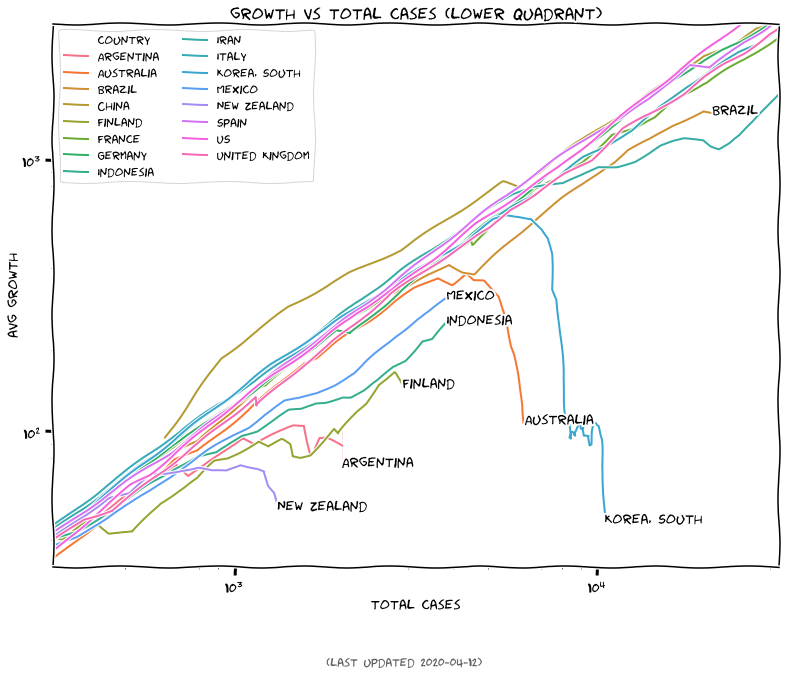

In [18]:
logPlot(
    "growth vs total cases (lower quadrant)",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/world-log-low.png",
    w,
    "country",
    "total cases",
    "avg growth",
    False,
    [10 ** 2.5, 10 ** 4.5],
    [10 ** 1.5, 10 ** 3.5],
)

In [ ]:
logPlot(
    "growth vs total cases (higher quadrant)",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/world-log-high.png",
    w,
    "country",
    "total cases",
    "avg growth",
    False,
    [10 ** 4, 10 ** 6],
    [10 ** 3, 10 ** 5],
)

In [ ]:
logPlot(
    "growth vs total cases (log)",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/world-log.png",
    w,
    "country",
    "total cases",
    "avg growth",
    True,
)

In [ ]:
logPlot(
    "world vs COVID",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/total-active-log.png",
    world[world["country"] == "World"],
    "country",
    "active cases",
    "avg growth",
    True,
    "",
    "",
    False,
)

In [ ]:
logPlot(
    "growth vs total cases",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/germany-total-log-few.png",
    de[de["state"].isin(stateList)],
    "state",
    "total cases",
    "avg growth",
    True,
)

In [ ]:
logPlot(
    "growth vs active cases in Germany",
    "(last updated " + str(datetime.date.today()) + ")",
    "/var/www/html/germany-active-log-few.png",
    de[de["state"].isin(stateList)],
    "state",
    "active cases",
    "avg growth",
    True,
)